<h2> Quantum Representation of Multi Wavelength Images </h2>
<h2> The Implementation using <span style="color:violet;"> Qiskit and IBM Quantum Computer </span> </h2>
<hr>

<br>
First,install Python libraries using <span style="color:red;"> PIP </span> commands below
<li> %pip install pillow </li>
<li> %pip install qiskit </li>
<li> %pip install stim </li>
<li> %pip install qiskit_aer </li>
<li> %pip instal numpy </li>
<li> %pip instal matplotlib </li>
<li> %pip install pylatexenc </li>
<li> %pip install qiskit-ibm-runtime </li>

In [1]:
from PIL import Image
import numpy as np
import typing
from dataclasses import dataclass
from qiskit import QuantumRegister, QuantumCircuit
from qiskit import transpile
from qiskit.version import get_version_info
from qiskit_aer import AerSimulator
from qiskit_aer.version import get_version_info as aerver
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
import matplotlib.pyplot as plt

In [2]:
print(f'Qiskit Version: {get_version_info()}')
print(f'Aer Version: {aerver()}')

Qiskit Version: 1.3.0
Aer Version: 0.15.1


<br>
<h3> Some tools to use in future </h3>
<hr>

In [3]:
def map_coord(x: int, y: int, w: int, h: int) -> int:
    """
    Maps the (X, Y) to single value.
    """
    
    __m = np.arange(w*h, dtype=int).reshape(h, w)
    return __m[x][y]

def convert_binary(x: int, padding: int) -> str:
    """
    Converts X integer to binary string.
    """

    return f'{x:0{padding}b}'

@dataclass
class fImage:
    width: int
    height: int
    depth: int
    channel: int
    evals: dict

<br>
<h2> Open an image and reshape for future usage </h2>
<hr>

In [4]:
def open_image(image_path: str) -> fImage:
    image = Image.open(image_path)
    image = image.convert('RGBA')
    pixels = image.load()

    # RGBA is 4 channel and bitdepth is 8.
    # Color bit depth is adaptable while channel is not.
    channel_count = 4
    color_depth = 8

    h = np.log2(image.height)     
    w = np.log2(image.width)
        
    pixel_info_dict: typing.Dict[str: typing.Dict[str: str]] = dict()
    
    # Scans the pixel values into dict.
    for y in range(image.height):
        for x in range(image.width):
            yindex_str = convert_binary(y, int(np.ceil(h)))
            xindex_str = convert_binary(x, int(np.ceil(w)))
            
            index_binstr = yindex_str+xindex_str
            pixel_info_dict[index_binstr] = dict()
            
            # Scans the RGBA into indexed dict.
            for z in range(channel_count):
                mindex_binstr = convert_binary(z, int(np.log2(channel_count)))
                pindex_binstr = convert_binary(pixels[x, y][z], color_depth)
                pixel_info_dict[index_binstr][mindex_binstr] = pindex_binstr

    df = fImage(image.width, image.height, color_depth, channel_count, pixel_info_dict)
    return image, df

<br>
Open file returns dictionary like below:
<br> Dictionary = {
<br> &emsp;&emsp; Pixel_Index0 = {RIndex: RValue, GIndex: GValue, BIndex: BValue, AIndex: AValue, ... },
<br> &emsp;&emsp; Pixel_Index0 = {RIndex: RValue, GIndex: GValue, BIndex: BValue, AIndex: AValue, ... }, 
<br> &emsp;&emsp; ... }
<hr>

In [5]:
org_image, df = open_image("8x8_test.png")
print(f'Image Size = {df.width}x{df.height}')
print(f'{"Pixel Ind":<12} | {"Color Ind":<12} | {"Color Value":<12}')
print(f'-----------------------------------------------------------')
skip = False
for i, pindex_binstr in enumerate(df.evals.keys()):
    if len(df.evals.keys()) < 10:
        for cindex_binstr in df.evals[pindex_binstr].keys():
            print(f'{pindex_binstr:<12} | {cindex_binstr:<12} | {df.evals[pindex_binstr][cindex_binstr]:<12}')
        print(f'-----------------------------------------------------------')
    else:
        if i < len(df.evals.keys())*1/20 or i >= len(df.evals.keys())*18/20:
            for cindex_binstr in df.evals[pindex_binstr].keys():
                print(f'{pindex_binstr:<12} | {cindex_binstr:<12} | {df.evals[pindex_binstr][cindex_binstr]:<12}')
            print(f'-----------------------------------------------------------')
        else:
            if not skip:
                print(f'{"...":<12} | {"...":<12} | {"...":<12}')
                print(f'{"...":<12} | {"...":<12} | {"...":<12}')
                print(f'{"...":<12} | {"...":<12} | {"...":<12}')
                skip = True

Image Size = 8x8
Pixel Ind    | Color Ind    | Color Value 
-----------------------------------------------------------
000000       | 00           | 11111111    
000000       | 01           | 00000000    
000000       | 10           | 00000000    
000000       | 11           | 11111111    
-----------------------------------------------------------
000001       | 00           | 00000000    
000001       | 01           | 00000000    
000001       | 10           | 11111111    
000001       | 11           | 11111111    
-----------------------------------------------------------
000010       | 00           | 00000000    
000010       | 01           | 11111111    
000010       | 10           | 00000000    
000010       | 11           | 11111111    
-----------------------------------------------------------
000011       | 00           | 11111111    
000011       | 01           | 11111111    
000011       | 10           | 00000000    
000011       | 11           | 11111111    
------------

<br>
<h3> Generate the QRM circuit from given reshaped image data</h3>
<h4> $$ \begin{aligned} \text{Qubit count} =& \; 2*n + q + c \\ n =& \; 2^n\times2^n \;\; \text{Image Size}\\ q =& \; 2^q\;\; \text{Color Depth} \\ c =& \; 2^c \;\; \text{Channel Count}\end{aligned}$$ </h4>
<hr>

In [6]:
def generate_QRMW_qiskit_circuit(image_info: fImage):
    ny_qubit_count = int(np.log2(image_info.height))
    nx_qubit_count = int(np.log2(image_info.width))
    c_qubit_count = int(np.log2(image_info.channel))
    q_qubit_count = int(image_info.depth)
    qubit_count = ny_qubit_count + nx_qubit_count + c_qubit_count + q_qubit_count
    print(f'Qubit count for QRMW image: {qubit_count}')

    if qubit_count > 24:
        mg = 'Qubit count greter then 24 is not recommended for qiskit simulation.'
        raise MemoryError(mg)

    # Add Hadamards on pixel index and color index qubits.
    circuit = QuantumCircuit(qubit_count, qubit_count)
    circuit.h(range(0, ny_qubit_count))
    circuit.h(range(ny_qubit_count, ny_qubit_count+nx_qubit_count))
    circuit.h(range(ny_qubit_count+nx_qubit_count, ny_qubit_count+nx_qubit_count+c_qubit_count))

    for pindex_binstr in image_info.evals.keys():
        for cindex_binstr in image_info.evals[pindex_binstr].keys():
            cpindex_binstr = pindex_binstr+cindex_binstr
            xcircuit = QuantumCircuit(q_qubit_count) 
            for i in range(q_qubit_count):
                if image_info.evals[pindex_binstr][cindex_binstr][i] == '1':
                    xcircuit.x(i)
            xgate = xcircuit.to_gate()
            circuit.append(xgate.control(len(cpindex_binstr), 
                                         label=cpindex_binstr, 
                                         ctrl_state=cpindex_binstr[::-1]),
                                         circuit.qubits)
            circuit.barrier()
    
    circuit.measure(range(qubit_count), range(qubit_count))
    return circuit

<br>
<h3> Aer Normal Simulator Result </h3>
<hr>

In [7]:
qrmw_qiskit_circuit = generate_QRMW_qiskit_circuit(df)
sim = AerSimulator()
transpiled_circuit = transpile(qrmw_qiskit_circuit, sim, optimization_level=3)
job =  sim.run(transpiled_circuit, shots=2**20)
print(f'Simulation time take: {job.result().metadata['time_taken_execute']}')
qiskit_result = job.result().get_counts()

Qubit count for QRMW image: 16
Simulation time take: 0.477359193


<br>
<h3> Regenerate the image from Qiskit simulation result </h3>
<hr>

In [37]:
def regenerate_image(counts, channel_len=4, color_depth=8):
    fv = list(counts.keys())[0]
    ch = int(np.log2(channel_len))
    n = int((len(fv) - ch - color_depth)/2)
    w = int(2**n)
    h = int(2**n)

    rgba_data = np.zeros(shape=(h, w, channel_len), dtype=np.uint8)
    for cts in counts:
        cts = cts[::-1]
        ybin = cts[: n]
        xbin = cts[n: 2*n]
        wbin = cts[2*n: 2*n+ch]
        qbin = cts[2*n+ch: ]
        rgba_data[int(ybin, 2)][int(xbin, 2)][int(wbin, 2)] = int(qbin, 2)
        
    image = Image.fromarray(rgba_data.astype(np.uint8), mode='RGBA')
    return image

<br>
<h2> Compare orginal image and recreated image side by side </h2>
<hr>

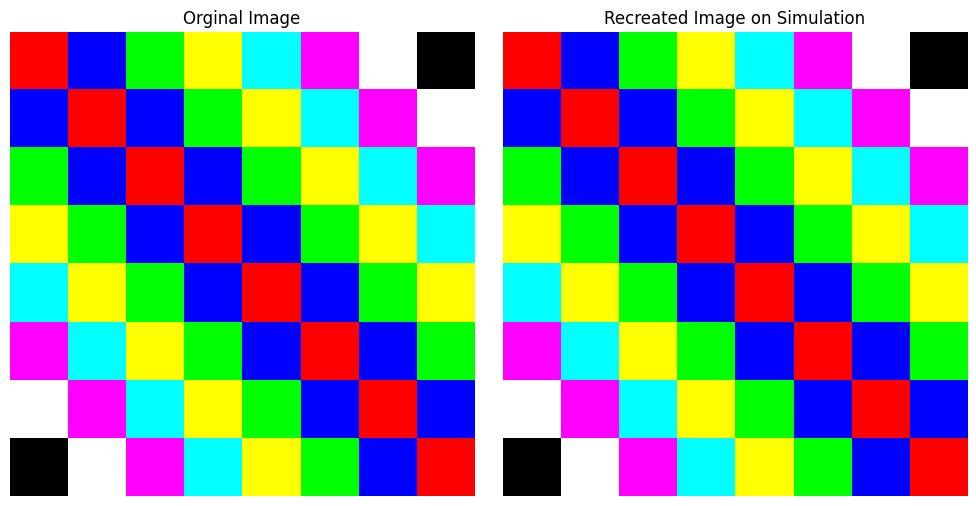

In [9]:
reg_image = regenerate_image(qiskit_result)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(org_image)
axes[0].axis('off')
axes[0].set_title('Orginal Image')

axes[1].imshow(reg_image)
axes[1].axis('off')
axes[1].set_title('Recreated Image on Simulation')
plt.tight_layout()
plt.show()

<br>
<h2> Actual simulation on Quantum Computer </h2>
<hr>

In [10]:
# Connect to the service
tkn = ''
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=tkn,
)
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=qrmw_qiskit_circuit.num_qubits)
print('Using IBM Machine: ', backend.name)

# Test small test file
org_image, df = open_image("2x2_test.png")
qrmw_qiskit_circuit = generate_QRMW_qiskit_circuit(df)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_circuit = pm.run(qrmw_qiskit_circuit)

# Check actual gate counts.
print(f">>> Circuit ops (ISA): {transpiled_circuit.count_ops()}")

Using IBM Machine:  ibm_sherbrooke
Qubit count for QRMW image: 12
>>> Circuit ops (ISA): OrderedDict({'rz': 13329, 'sx': 8789, 'ecr': 3761, 'x': 554, 'barrier': 16, 'measure': 12})


In [11]:
sampler = Sampler(mode=backend)
sampler.options.default_shots=8192
sampler.options.dynamical_decoupling.enable = True
sampler.options.twirling.enable_gates = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

In [22]:
job = sampler.run([(transpiled_circuit)])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cx7jprvtpsjg008c3ra0
>>> Job Status: QUEUED


In [34]:
# job = service.job(job.job_id())
job_result = job.result()
pub_result = job_result[0].data.c.get_counts()

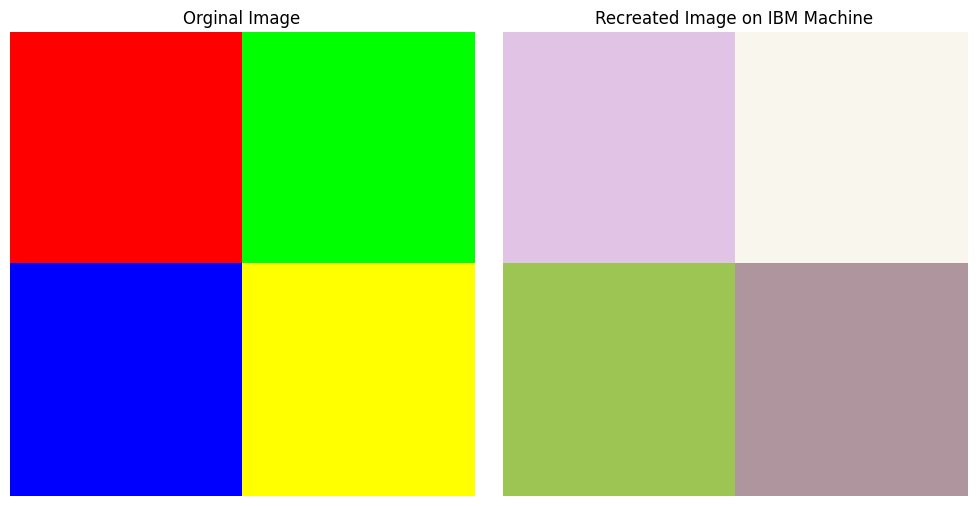

In [38]:
reg_image = regenerate_image(pub_result)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(org_image)
axes[0].axis('off')
axes[0].set_title('Orginal Image')

axes[1].imshow(reg_image)
axes[1].axis('off')
axes[1].set_title('Recreated Image on IBM Machine')
plt.tight_layout()
plt.show()